# **CINEMA E O SUCESSO FINANCEIRO - UMA LINHA DO TEMPO DA 7ª ARTE**

**SUMÁRIO**

0. Introdução
1. Bibliotecas
2. Data
3. Tratamento
4. Etapa 1: Análise de Dados
   1. Dados Lineares
   2. Dados Categóricos
      1. Numeração
5. Etapa 2: Análise Década-Década
   1. The 80s
   2. The 90s
   3. The 00s
   4. The 10s
   5. Resultado
6. Conclusão

# Introdução

Em 1985 os irmãos Lumiere levaram cerca de 20 pessoas para ver a primeira sessão de cinema da história. De lá para cá a indústria cinematográfica se tornou a principal potência do entretenimento e gera bilhões de dólares de lucro anualmente. E no meio disso tudo, filmes de diferentes produtoras, gêneros e diversos formatos são lançados com dois principais objetivos: entreter e trazer lucro para os produtores. 

A idéia proposta deste trabalho é utilizar de uma base de dados de filmes já lançados para encontrar possíveis correlações entre características dos filmes e o lucro alcançado, e padrões nessas correlações, analisando por década e no contexto geral, tentando formar uma possível “receita” que aumente a probabilidade de um filme ser um sucesso financeiro.

# Bibliotecas

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

# Data

In [2]:
df_raw = pd.read_csv("../input/movies/movies.csv")
df_raw.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [3]:
# Conferindo se existe algum dado ausente
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


# Tratamento

É possível notar que algumas colunas tem valores nulos.

Como nosso propósito é analisar a correlação entre características dos filmes e quanto de dinheiro (*gross*) ele fez, precisamos tratar essas colunas de forma a ter uma base de dados confiável.

In [4]:
# Clusterizando o tempo de filme em intervalos para conseguirmos analisar melhor
df_raw.loc[:, ['runtime']] = pd.cut(df_raw['runtime'], bins=6)

# Dropar todas as linhas que não tem valores para os seguintes critérios
df = df_raw.dropna(axis=0, subset=['gross', 'votes', 'runtime', 'budget', 'rating', 'genre'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5423 entries, 0 to 7652
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      5423 non-null   object  
 1   rating    5423 non-null   object  
 2   genre     5423 non-null   object  
 3   year      5423 non-null   int64   
 4   released  5423 non-null   object  
 5   score     5423 non-null   float64 
 6   votes     5423 non-null   float64 
 7   director  5423 non-null   object  
 8   writer    5423 non-null   object  
 9   star      5423 non-null   object  
 10  country   5423 non-null   object  
 11  budget    5423 non-null   float64 
 12  gross     5423 non-null   float64 
 13  company   5421 non-null   object  
 14  runtime   5423 non-null   category
dtypes: category(1), float64(4), int64(1), object(9)
memory usage: 641.1+ KB


# Análise dos Dados

Para começar vamos plotar alguns gráficos para analisarmos os dados.

Iniciaremos com os dados lineares que temos para comparar, esses são: **ano de lanamento**, **nota do filme**, **número de usuários que deram alguma nota**, **orçamento** e o próprio **dinheiro gerado**.

# Dados Lineares

Para nossa análise inicial se há relação entre esses dados olharemos para a **covariância** entre elas utilizando o **coeficiente de correlação de Pearson**.

Text(87.0, 0.5, 'Movie Features')

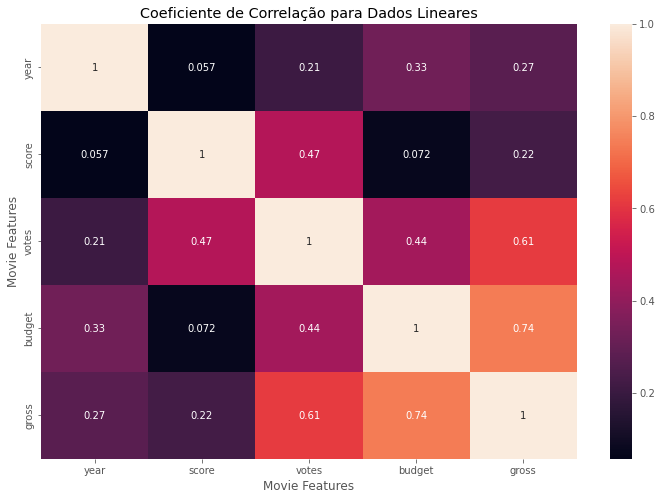

In [5]:
correlation_matrix = df.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True)
plt.title('Coeficiente de Correlação para Dados Lineares')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')

Baseado no que vemos no mapa de calor podemos concluir o seguinte:

1. o ano de lançamento e nota do filme pouco tem relação com o dinheiro gerado pelo filme;
2. o número de votos dos usuários computados para um filme também é um indicativo de que o filme gerou mais dinheiro;
3. o orçamento é o principal dado linear relacionado a quanto dinheiro um filme gera.

Como outra medida comparativa vamos também conferir o gráfico de regressão linear das categorias de dados lineares.

(0.0, 2000000000.0)

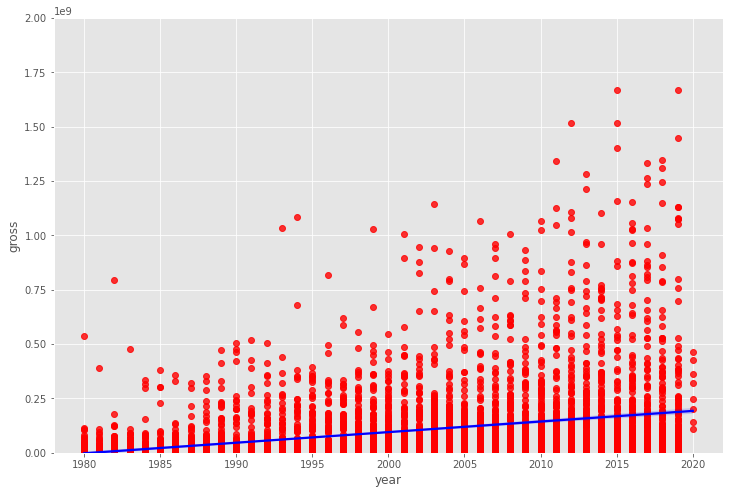

In [6]:
# Regressão Linear entre anos de lançamento e dinheiro gerado
sns.regplot(x='year', y='gross', data = df, scatter_kws={'color':'red'}, line_kws={'color':'blue'})
plt.ylim([0,2*10**9])

(0.0, 2000000000.0)

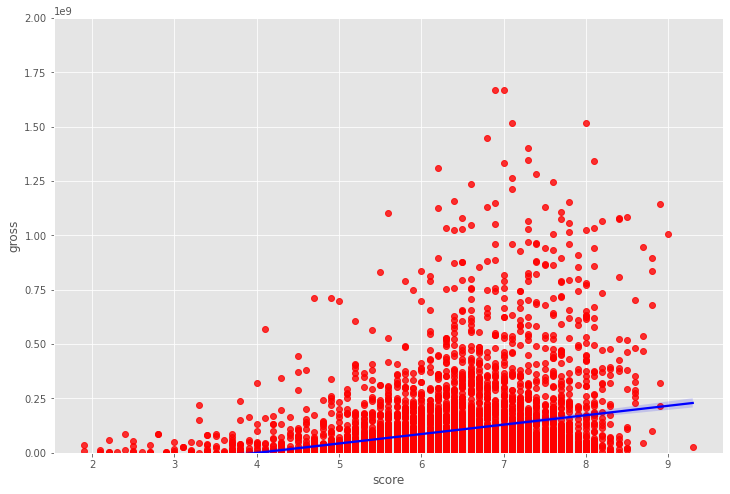

In [7]:
# Regressão Linear entre nota do filme e dinheiro gerado
sns.regplot(x='score', y='gross', data = df, scatter_kws={'color':'red'}, line_kws={'color':'blue'})
plt.ylim([0,2*10**9])

(0.0, 2000000000.0)

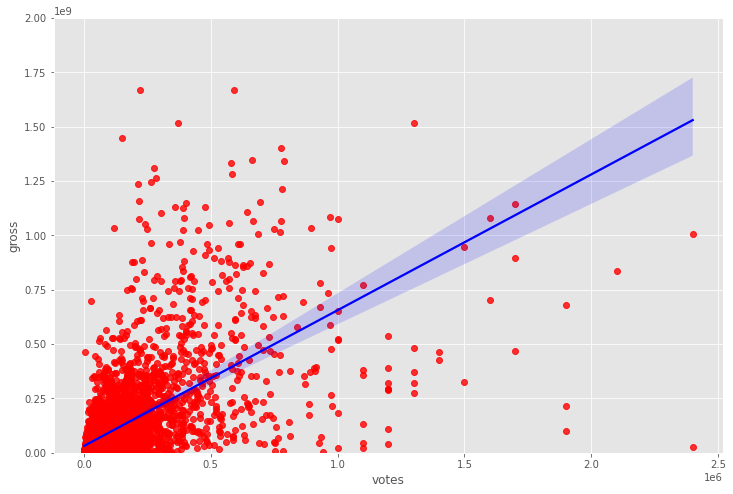

In [8]:
# Regressão Linear entre número de votos e dinheiro gerado
sns.regplot(x='votes', y='gross', data = df, scatter_kws={'color':'red'}, line_kws={'color':'blue'})
plt.ylim([0,2*10**9])

(0.0, 2000000000.0)

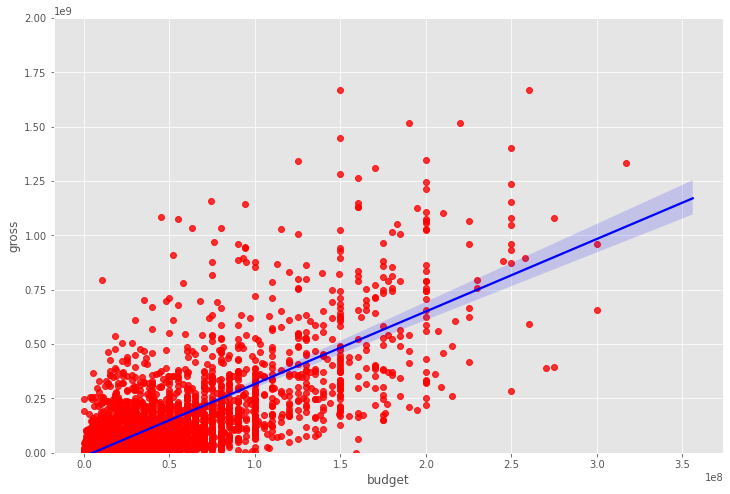

In [9]:
# Regressão Linear entre orçamento e dinheiro gerado
sns.regplot(x='budget', y='gross', data = df, scatter_kws={'color':'red'}, line_kws={'color':'blue'})
plt.ylim([0,2*10**9])

Após o segundo comparativo podemos ver que as relações de covariância encontradas anteriormente continuam sendo as mesmas. Logo, podemos confirmar que dos dados lineares que nós temos, os que, provavelmente, afetariam quanto de dinheiro um filme gera são: seu orçamento e quantos votos ele recebeu, o que faz sentido pois representam investimento e popularidade de um filme.

# Dados Categóricos

Agora vamos analisar os dados categóricos que temos na nossa base de dados, em especial os seguintes: **gênero**, **tempo de filme**, e **classificação**.

Primeiramente vamos ver a frequência em que cada categoria de cada dado aparece com relação ao *gross* de cada filme.

<AxesSubplot:xlabel='genre', ylabel='gross'>

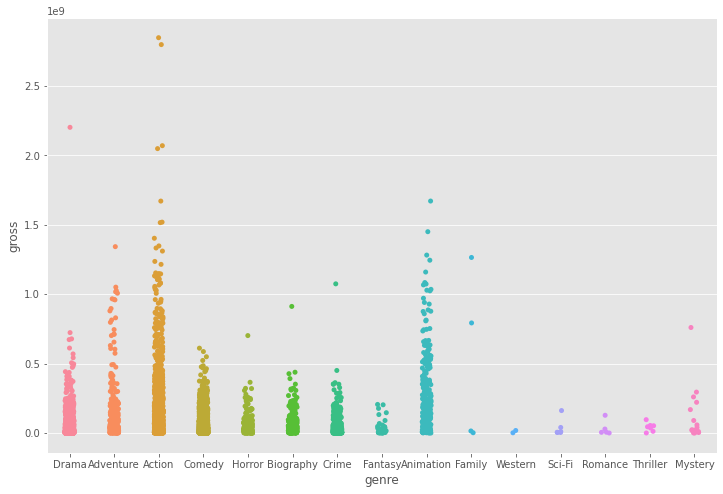

In [10]:
# Diagrama de dispersão categórico entre gênero e gross 
sns.stripplot(data=df, y="gross", x="genre")

<AxesSubplot:xlabel='runtime', ylabel='gross'>

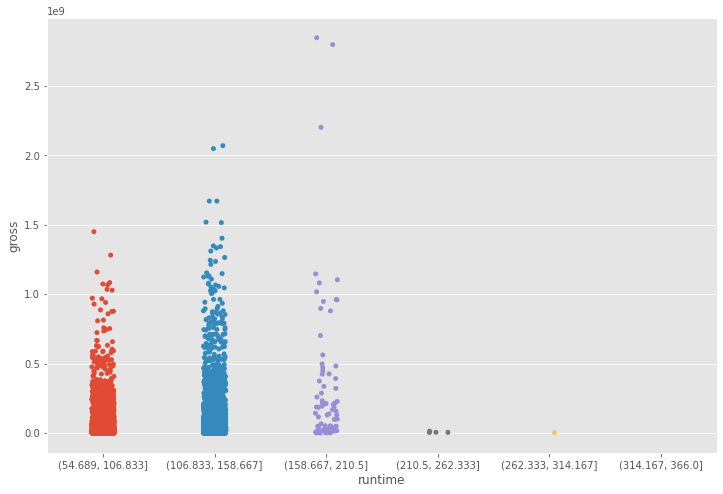

In [11]:
# Diagrama de dispersão categórico entre intervalos de tempo de duração e gross
sns.stripplot(data=df, y="gross", x="runtime")

<AxesSubplot:xlabel='rating', ylabel='gross'>

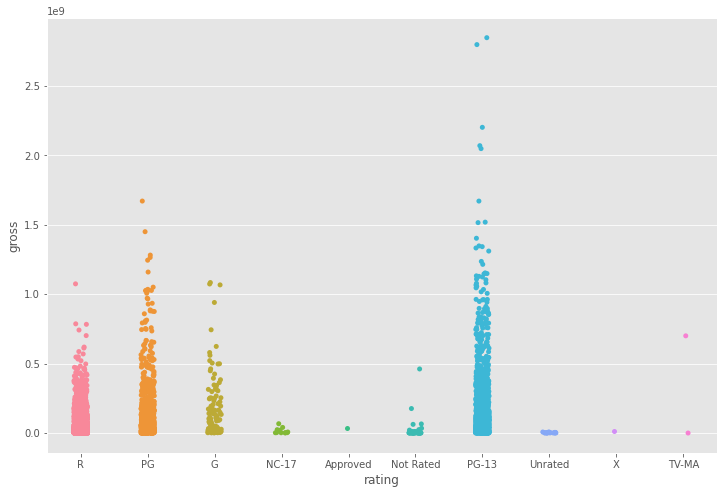

In [12]:
# Diagrama de dispersão categórico entre classificação e gross
sns.stripplot(data=df, y="gross", x="rating")

Ao analisarmos os gráficos conseguimos ver que algumas categorias específicas aparecem com mais frequência que outras. Apesar disso, elas seguem concentradas na parte de baixo do eixo Y, que representa o *gross* do filme.

Isso significa que a correlação com quanto o filme gera continua sendo baixa, já que valores mais altos seguem escassos para as três variáveis e quando aparecem são nas categorias mais frequentes, o que é o mais provável estatísticamente de acontecer.

Para termos certeza se há uma correlação precisamos analisá-la de alguma forma específica e para isso utilizaremos o método de Pearson novamente, mas como os dados são categóricos, precisamos antes tratá-los.

# Numeração

Para analisarmos nossas variáveis categóricas vamos identificá-las com valores numéricos específicos.

Ex: ao invés de termos 6 strings que representam intervalos de tempo na coluna "runtime", cada intervalo receberá um valor, como: 0,1,2,3,4 e 5. Assim eles ainda serão distinguíveis entre si e poderemos utilizá-los em alguns métodos de indentificação de correlação. Neste caso usaremos o método Pearson novamente.

In [13]:
# Copiando a tabela para não mudar a referência original
df_numerized = df.copy()

# "Numerizando" colunas do tipo object ou category
for col_name in df_numerized.columns:
    if(df_numerized[col_name].dtype == 'object' or df_numerized[col_name].dtype == 'category'):
        df_numerized.loc[:, [col_name]] = df_numerized[col_name].astype('category')
        df_numerized.loc[:, [col_name]] = df_numerized[col_name].cat.codes
df_numerized.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,4694,6,6,1980,1304,8.4,927000.0,1797,2833,699,46,19000000.0,46998772.0,1426,1
1,3931,6,1,1980,1127,5.8,65000.0,1579,1159,214,47,4500000.0,58853106.0,452,0
2,3642,4,0,1980,1359,8.7,1200000.0,757,1819,1157,47,18000000.0,538375067.0,945,1
3,204,4,4,1980,1127,7.7,221000.0,889,1414,1474,47,3500000.0,83453539.0,1108,0
4,732,6,4,1980,1170,7.3,108000.0,719,352,271,47,6000000.0,39846344.0,1083,0


Agora podemos plotar um novo mapa de calor geral com as colunas de variáveis categóricas também.

Text(87.0, 0.5, 'Movie Features')

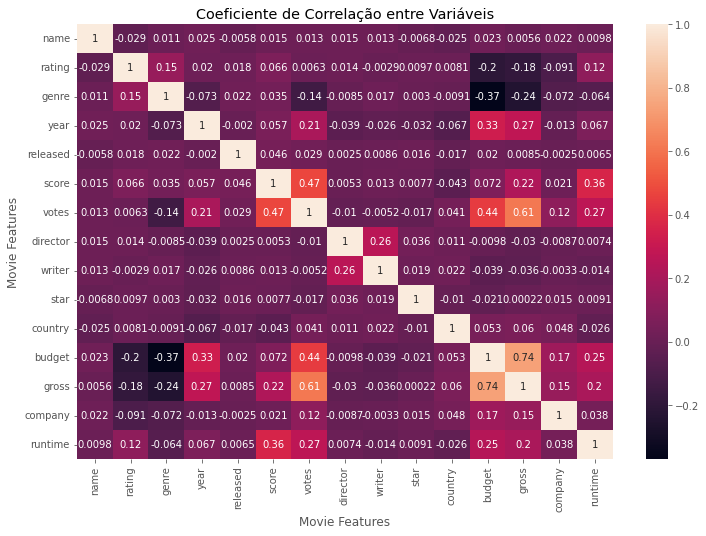

In [14]:
correlation_matrix = df_numerized.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True)
plt.title('Coeficiente de Correlação entre Variáveis')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')

Com esse novo mapa podemos concluir que:

1. o que descobrimos anteriormente se mantém, votos e orçamento tendem a ter uma correlação mais significativa com o *gross* de um filme;
2. a avaliação e o gênero de um filme tem um coeficiente levemente negativo, então algumas avaliaçoes baixas ou alguns gêneros específicos podem indicar que o filme não gerou um *gross* tão alto. Ainda sim é uma correlação pouco relevante.

Para fazer um último comparativo, utilizaremos a Ridge Regression para comparar às correlações encontradas entre as melhores, medianas e piores variáveis independentes.

In [15]:
X=df_numerized.loc[:,['budget', 'votes']] ## independent features
y=df_numerized.loc[:,['gross']] ## dependent features

ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X,y)

print("Score da regressão de Ridge para as variáveis independentes ORÇAMENTO e VOTOS:\n")
print(ridge_regressor.best_score_,'\n')
print("******************************************************************************\n")

X=df_numerized.loc[:,['year','score', 'company']] ## independent features
y=df_numerized.loc[:,['gross']] ## dependent features

ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X,y)

print("Score da regressão de Ridge para as variáveis independentes ANO, PONTUAÇÃO e COMPANHIA:\n")
print(ridge_regressor.best_score_,'\n')
print("******************************************************************************\n")

X=df_numerized.loc[:,['genre','rating']] ## independent features
y=df_numerized.loc[:,['gross']] ## dependent features

ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X,y)

print("Score da regressão de Ridge para as variáveis independentes GÊNERO e CLASSIFICAÇÃO:\n")
print(ridge_regressor.best_score_, '\n')

Score da regressão de Ridge para as variáveis independentes ORÇAMENTO e VOTOS:

-1.3197048276132122e+16 

******************************************************************************

Score da regressão de Ridge para as variáveis independentes ANO, PONTUAÇÃO e COMPANHIA:

-3.0730990763887576e+16 

******************************************************************************

Score da regressão de Ridge para as variáveis independentes GÊNERO e CLASSIFICAÇÃO:

-3.4178491502892884e+16 



Como é possível perceber, mesmo com um treinamento baixo e relativamente poucas iterações, os scores mostram que as variáveis orçamento e votos realmente tendem a ter uma correlação mais forte com o *gross* de cada filme.

# Etapa 2: Análise Década-Década

Conseguimos concluir algumas coisas com relação às características dos filmes e quanto de dinheiro eles produziram. Apesar disso, sabemos que quando trabalhamos com o fator dinheiro é difícil tratar dados de um intervalo tão grande de tempo como a mesma coisa, já que quanto dinheiro um filme investiu de orçamento e conseguiu de retorno, por exemplo, tenderá a ser maior quanto mais recente o filme for.

Faremos nessa etapa então uma experiência, checando novamente as correlações mas para dataframes segmentados por cada década de lançamento dos filmes, sendo elas: os anos **80**, **90**, **00** e **10**.

In [16]:
# Criação de um dataframe já "numerizado" e segmentado por década

df_80s = df_numerized[df_numerized['year'].between(1980, 1989)]

df_90s = df_numerized[df_numerized['year'].between(1990, 1999)]

df_00s = df_numerized[df_numerized['year'].between(2000, 2009)]

df_10s = df_numerized[df_numerized['year'].between(2010, 2019)]

# The 80s

Text(87.0, 0.5, 'Movie Features')

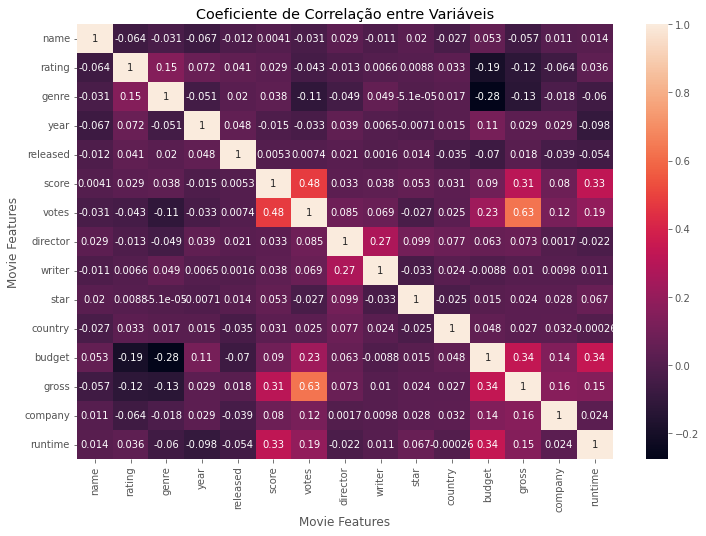

In [17]:
# Matriz de correlação
correlation_matrix = df_80s.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True)
plt.title('Coeficiente de Correlação entre Variáveis')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')

# The 90s

Text(87.0, 0.5, 'Movie Features')

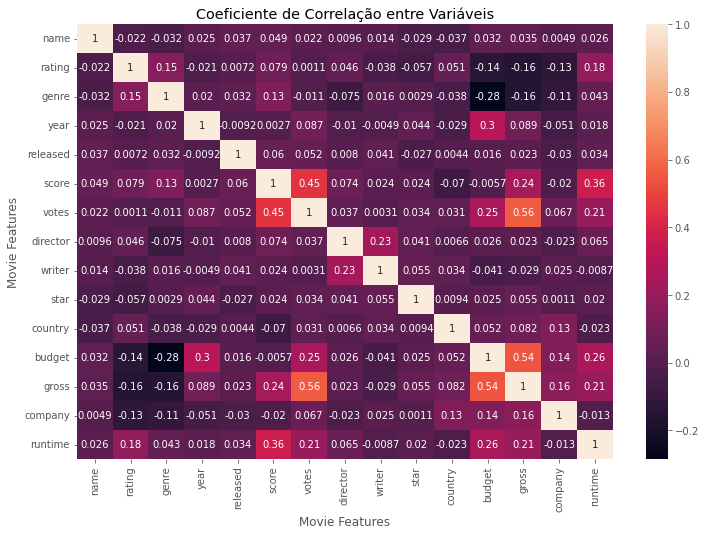

In [18]:
# Matriz de correlação
correlation_matrix = df_90s.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True)
plt.title('Coeficiente de Correlação entre Variáveis')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')

# The 00s

Text(87.0, 0.5, 'Movie Features')

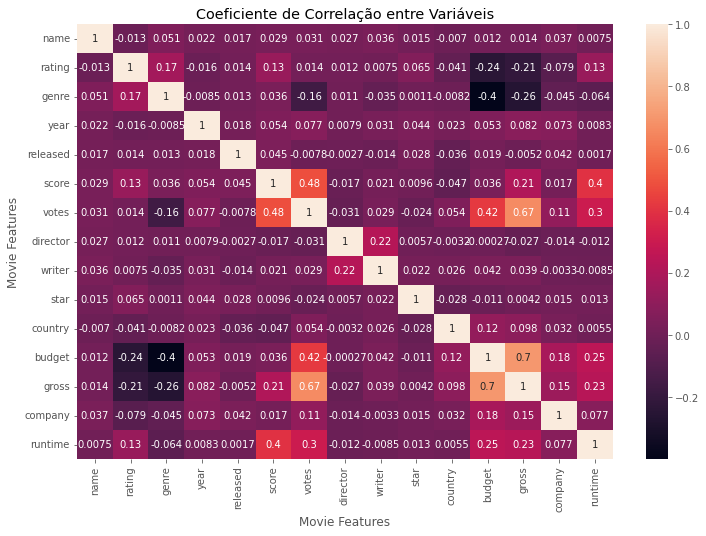

In [19]:
# Matriz de correlação
correlation_matrix = df_00s.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True)
plt.title('Coeficiente de Correlação entre Variáveis')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')

# The 10s

Text(87.0, 0.5, 'Movie Features')

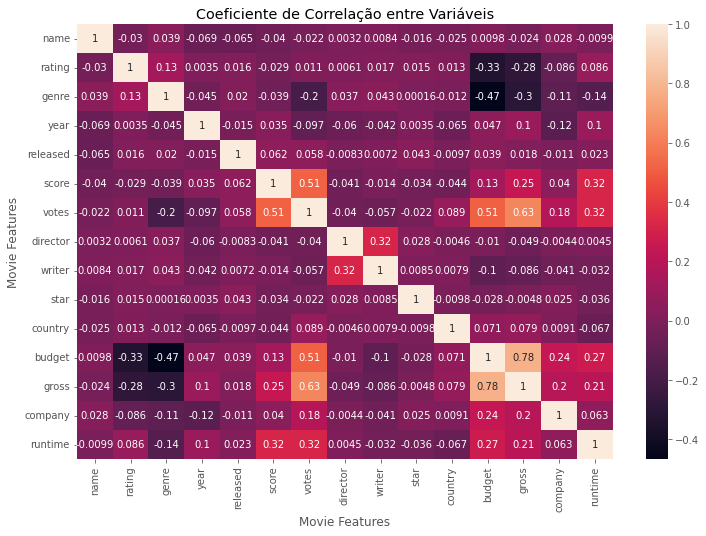

In [20]:
# Matriz de correlação
correlation_matrix = df_10s.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True)
plt.title('Coeficiente de Correlação entre Variáveis')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')

# Resultado

Após checar cada década, alcançamos as seguintes conclusões:

1. nas duas primeiras décadas a variável de orçamento tem uma correlação mais baixa, provavelmente porque os orçamentos dos filmes eram baixos e semelhantes. Assim, os filmes que se destacavam pouco tinham de vantagem nessa área;
2. já na duas últimas, as correlações se mantém semelhantes, sendo as mais significativas os votos e, principalmente, o orçamento do filme.

# Conclusão

Assim, após as análises feitas no banco de dados utilizado, podemos concluir que nos últimos 40 anos foram lançados filmes de diversos gêneros, durações e classificações, e o sucesso financeiro desses filmes está estatísticamente ligado a dois fatores: popularidade, quanto mais visto um filme é obviamente ele gera mais renda, e cada vez mais o seu orçamento, investimento em produção e elenco chama a atenção de mais pessoas.

Apesar disso, é extremamente difícil definir perfis de filmes que tendem a gerar mais dinheiro, mas é possível ver cada vez menos variedade nos estilos dos filmes.